<div id="container" style="position:relative;">
<div style="float:left"><h1> Predicting NHL Goal Scoring - Initial Modeling </h1></div>
<br>
    <br>
    <br>

***BrainStation Data Science Capstone Project*** <br/>
***Author:***  &ensp;    **Taylor Gallivan** <br/>
***Date:*** &ensp; **Sep-Nov 2023** 

## Introduction

This notebook is for preliminary modeling of NHL goal scoring, using the cleaned & processed dataset.  To this point, some limited feature engineering has been performed, mostly to encode categorical columns into numerical ones.

As a refresher, each row of the dataset has two unique identifiers:  a player id, and a season.  So, the data contained in a single entry is a player's statistics for the entirety of that season.  Some of the statistics are static across all entries for a given player id - for instance, their height, weight, and the position that they play.  Then there are the gameplay statistics, which are numerical statistics that describe the player's performance for that season - including, but not limited to:  goals, assists, points, shots on net, time on ice, etc.  Some stats are also broken down by situation:  even strength, power play, and short handed.  All of these numerical gameplay statistics have been divided by the number of games that the player parciticpated in that season, such that all of these gameplay statistics are on an equivalent per-game basis.

The initial modelling steps will be as follows:
1. Split the data into train and test splits
2. Scale the data
3. Fit & score a linear regression model
4. Review feature coefficients to guide further processing and feature engineering
5. Constrain next steps


In [115]:
# Importing packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting data
from sklearn.model_selection import train_test_split

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classifiers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [116]:
# load the data
df = pd.read_csv('NHL_data_clean_1.csv')

In [117]:
# check the head and tail
df

,player_id,name,height,weight,season_start_yr,player_age,midseason_trades,games_played,goals,game_winning_goals,...,tbl,tor,van,vgk,win,wsh,center,defenseman,left_wing,right_wing
0,8444894,Greg Adams,76,196,1984,21,0,36,0.333333,0.000000,...,0,0,0,0,0,0,0,0,1,0
1,8444894,Greg Adams,76,196,1985,22,0,78,0.448718,0.025641,...,0,0,0,0,0,0,0,0,1,0
2,8444894,Greg Adams,76,196,1986,23,0,72,0.277778,0.013889,...,0,0,0,0,0,0,0,0,1,0
3,8444894,Greg Adams,76,196,1987,24,0,80,0.450000,0.037500,...,0,0,1,0,0,0,0,0,1,0
4,8444894,Greg Adams,76,196,1988,25,0,61,0.311475,0.032787,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24498,8482116,Tim Stützle,72,197,2021,19,0,79,0.278481,0.050633,...,0,0,0,0,0,0,1,0,0,0
24499,8482116,Tim Stützle,72,197,2022,20,0,78,0.500000,0.038462,...,0,0,0,0,0,0,1,0,0,0
24500,8482245,Artem Zub,75,204,2020,25,0,47,0.063830,0.021277,...,0,0,0,0,0,0,0,1,0,0
24501,8482245,Artem Zub,75,204,2021,26,0,81,0.074074,0.000000,...,0,0,0,0,0,0,0,1,0,0


In [118]:
df.columns

Index(['player_id', 'name', 'height', 'weight', 'season_start_yr',
       'player_age', 'midseason_trades', 'games_played', 'goals',
       'game_winning_goals', 'power_play_goals', 'short_handed_goals', 'shots',
       'assists', 'points', 'power_play_points', 'short_handed_points',
       'plus_minus', 'penalty_minutes', 'hits', 'blocked', 'shifts',
       'total_toi', 'even_strength_toi', 'power_play_toi', 'short_handed_toi',
       'ana', 'ari', 'bos', 'buf', 'car', 'cbj', 'cgy', 'chi', 'col', 'dal',
       'det', 'edm', 'fla', 'lak', 'min', 'mtl', 'njd', 'nsh', 'nyi', 'nyr',
       'ott', 'phi', 'pit', 'sea', 'sjs', 'stl', 'tbl', 'tor', 'van', 'vgk',
       'win', 'wsh', 'center', 'defenseman', 'left_wing', 'right_wing'],
      dtype='object')

### 1. Split the data into train and test splits
Exclude points categories from the X features matrix to avoid potential multicollinearity between goals, assists, points.

In [119]:
# Assigning our features to X
X = df.drop(['player_id', 'name', 'goals', 'points', 'power_play_points', 'short_handed_points'], axis=1)

# Assigning our target to y
y = df['goals']

# Check
display(X)
print(y)

,height,weight,season_start_yr,player_age,midseason_trades,games_played,game_winning_goals,power_play_goals,short_handed_goals,shots,...,tbl,tor,van,vgk,win,wsh,center,defenseman,left_wing,right_wing
0,76,196,1984,21,0,36,0.000000,0.138889,0.000000,1.805556,...,0,0,0,0,0,0,0,0,1,0
1,76,196,1985,22,0,78,0.025641,0.128205,0.000000,2.589744,...,0,0,0,0,0,0,0,0,1,0
2,76,196,1986,23,0,72,0.013889,0.083333,0.000000,1.944444,...,0,0,0,0,0,0,0,0,1,0
3,76,196,1987,24,0,80,0.037500,0.150000,0.000000,2.837500,...,0,0,1,0,0,0,0,0,1,0
4,76,196,1988,25,0,61,0.032787,0.147541,0.000000,2.360656,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24498,72,197,2021,19,0,79,0.050633,0.088608,0.012658,2.227848,...,0,0,0,0,0,0,1,0,0,0
24499,72,197,2022,20,0,78,0.038462,0.128205,0.038462,2.923077,...,0,0,0,0,0,0,1,0,0,0
24500,75,204,2020,25,0,47,0.021277,0.000000,0.000000,0.829787,...,0,0,0,0,0,0,0,1,0,0
24501,75,204,2021,26,0,81,0.000000,0.000000,0.000000,1.135802,...,0,0,0,0,0,0,0,1,0,0


0        0.333333
1        0.448718
2        0.277778
3        0.450000
4        0.311475
           ...   
24498    0.278481
24499    0.500000
24500    0.063830
24501    0.074074
24502    0.056604
Name: goals, Length: 24503, dtype: float64


In [120]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=975)

# Check
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19602, 56) (4901, 56) (19602,) (4901,)


### 2. Scale the data
We don't particularly care about the spread of outliers so the default Standard Scaler is fine.

In [121]:
# Instantiate the scaler
SS = StandardScaler()

# Fit the scaler and transform both data subsets
X_train_ss = SS.fit_transform(X_train)
X_test_ss = SS.transform(X_test)

In [122]:
print(X_train_ss.shape, X_test_ss.shape)

(19602, 56) (4901, 56)


### 3. Fit & score model
This is the initial base model being ran with this dataset - keeping things simple with a standard Linear Regression linear model.

In [123]:
# instantiate linear regression model
linreg_model = LinearRegression()

# fit the model
linreg_model.fit(X_train_ss, y_train)

# get y predictions on test data
y_predictions = linreg_model.predict(X_test_ss)

# print R2 score and MSE
print(f"R2 score for test data: {r2_score(y_test, y_predictions):.3f}")
print(f"Mean Squared Error for test data: {mean_squared_error(y_test, y_predictions):.3f}")

R2 score for test data: 0.880
Mean Squared Error for test data: 0.002


R2 is the primary scoring metric for linear regression models - it is a measure of how much of the total variance in our target variable, `goals`, was explained by the model.  A perfect model would have an R2 value of 1, but such a result would suggest strong multicollinearity (i.e., some combination of model features being able to perfectly predict the target variable).  Conversely, an R2 score of 0 means that the model is no better at predicting the target variable than simply guessing the mean.  

With that context in mind, an R2 score of 0.880 can be interpreted as follows:  the model explains 88.0% of the variation in our dependent variable.  Considering that this is the base model, an accuracy score of 88.0% is quite high.

The second metric calculated was Mean Squared Error (MSE), which is a measure of how close the models predictions are to the actual values:  R2 answers the question "How many times did the model get it right?", MSE answers the question "When the model was wrong, how far off was it (from the correct value)?".  MSE is based on the squared value of errors, so an MSE of 0.002 is (very) questionably low.  Taken together, these scoring metrics suggest overfitting of our  model - let's review the accuracy score for our training data.

In [124]:
# scoring the training data
print(f"Train score on scaled data: {linreg_model.score(X_train_ss, y_train):.3f}")

Train score on scaled data: 0.873


In sklearn the .score metric for Linear Regression is R2, so the above code produces an equivalent scoring metric for how our training data performed with the model.  The accuracy score is very similar, coming in slightly lower than for the test data, at 87.3%.  The accuracy scores for our two models do not suggest overfitting when taken on their own, but with the context of the MSE score, overfitting still seems very likely.

Considering our target feature, it is an average number of goals scored by a player for a specific season, averaged over the number of NHL games that they appeared in, and stored as a float value.  What is likely going on here is that the model is having trouble predicting the exact decimal point value of the target feature, but is getting very darn close each time.

There are some series tweaks that need to be made the dataset before running the next round of modelling, and those will be addressed in full at the end of the notebook; however, the next step is to extract the feature coefficients for analysis.

### 4. Review feature coefficients

In [125]:
# put coefficients in a dataframe
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linreg_model.coef_.flatten()  # Flatten in case it's a 2D array with a single column
})

# sort values in place, and reset index
coefficients.sort_values(by='Coefficient', ascending=False, inplace=True, ignore_index=True)

In [126]:
# take a look
coefficients

,Feature,Coefficient
0,even_strength_toi,1.321004e+01
1,power_play_toi,5.707822e+00
2,short_handed_toi,4.701498e+00
3,power_play_goals,5.786938e-02
4,shots,3.875052e-02
5,game_winning_goals,2.511495e-02
6,short_handed_goals,1.360576e-02
7,plus_minus,1.265653e-02
8,assists,4.127847e-03
9,games_played,2.100353e-03


It will be helpful to view the top coefficients, both positive and negative, graphically.  Create two dataframes to hold the top 10 values at each end of the spectrum (i.e., the 10 'most positive' and 10 'most negative' coefficients)

In [127]:
# new dataframes
top_pos = coefficients.loc[:9, ['Feature', 'Coefficient']]
top_neg = coefficients.loc[55:46:-1, ['Feature', 'Coefficient']]

# invert the dataframes
top_pos = top_pos[::-1]
top_neg = top_neg[::-1]

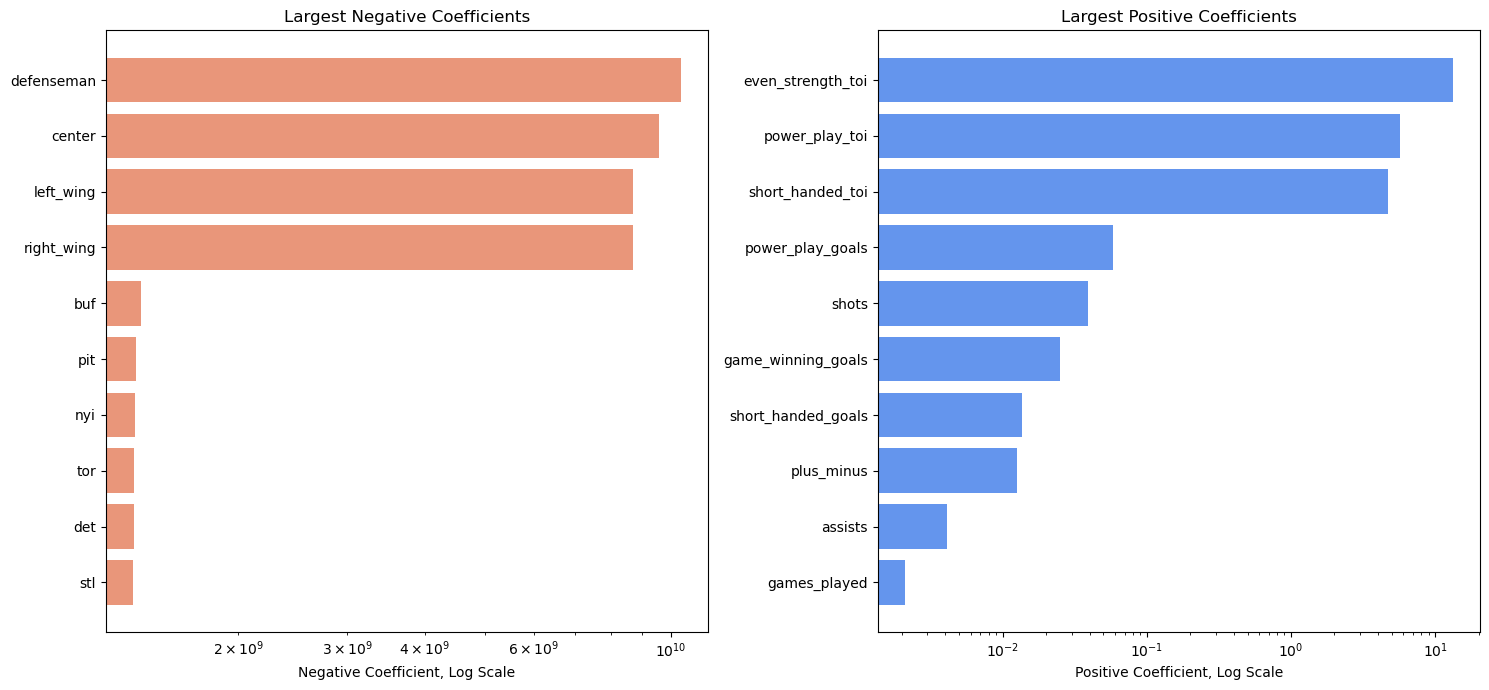

In [128]:
# Create side by side subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# First plot
axes[0].barh(top_neg['Feature'], top_neg['Coefficient'].abs(), tick_label=(top_neg['Feature']), color='darksalmon')
axes[0].set_title("Largest Negative Coefficients")
axes[0].set_xlabel("Negative Coefficient, Log Scale")
axes[0].set_xscale('log')

# Second plot
axes[1].barh(top_pos['Feature'], top_pos['Coefficient'], tick_label=(top_pos['Feature']), color='cornflowerblue')
axes[1].set_title("Largest Positive Coefficients")
axes[1].set_xlabel("Positive Coefficient, Log Scale")
axes[1].set_xscale('log')

# Adjust spacing between the two subplots
plt.tight_layout()

plt.show()

Given that the model needs some serious tweaking, these coefficients should be taken with a grain of salt.  However, the values of the positive coefficients do make some good sense:  several categories that were anticipated to be strong predictors of goal output are in the top 10, including `even_strength_toi`, `power_play_toi`, `power_play_goals`, and `shots`.  

The negative coefficients are a bit harder to rectify, especially because of the magnitude of the values.  For comparison, the largest positive coefficient is 13.2, while the largest negative coefficient is -10.4 x 10^10.  If these results persist after the planned adjustments to the dataset, some further investigation may be warranted.

### 5. Next steps
The main step that needs to be taken is fixing the target variable for each entry:  what we really want to know is how well we can predict a player's output for the *next* season, based on their recent stats.  This will require some manipulating of the main DataFrame, to include players goal total from season 'n' in their statline for season 'n-1'.  The notion of 'recent stats' can also be interpreted in several ways:  it could be 

Below are some of the data processing / feature engineering ideas that will be investigated as part of the next round of modeling:

- consider a feature that is the average number of games that a player missed in the 2 trailing seasons
- consider number of career NHL games played prior to each season (each entry), for a given player
- adjust goals scoring for era --> there are widely used protocols for this
- weighted average of goals in 2 trailing seasons
- % change in ice time (all ice times) over trailing 2 seasons
- create a feature for career average shooting percentage
- ordinal encoding (weighting) based on era?  weighting based on number of seasons played? --> one idea is to give more weight to players who have a large density of data on which the average calculations are based on - some players in the dataset have played upwards of 20 seasons, others have played as few as 3...give more weight to the players who have had lengthy careers
- need an offseason team change feature, since an individual datapoint does not provide context about what team a player played for in the season prior
- try including player IDs - if trained on a neural network, the model might be able to recognize trends for individual players 